In [1]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from bin_time_mz import bin_time
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import *

# Load the Model

In [3]:
my_model = tf.keras.models.load_model('siamese.h5')

2023-06-20 06:53:43.679855: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 06:53:46.787441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14639 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 7.0


# Load the Data

In [5]:
table = {}

for i in glob.glob("applicability_data/*_ms1.csv"):
    
    df = pd.read_csv(i, index_col=0)
    binned = bin_time(df, rt_window=1, mz_window=1.0005079)
    table[i.replace("applicability_data/","").replace("_ms1.csv", "")] = binned
    

In [6]:
df = pd.DataFrame(table).transpose()
df = df.apply(lambda x: x/x.max(), axis=1)
df = df.drop(columns=[i for i in range(0,100)])

In [7]:
test = pd.read_csv("applicability_data/similarity_pairs_psms.txt")
test

,PID1,PID2,Jaccard_Index
0,PXD009723,PXD012225,0.000000
1,PXD024547,PXD009514,0.000000
2,PXD011076,PXD009514,0.001123
3,PXD020717,PXD009514,0.001162
4,PXD012225,PXD009514,0.002165
...,...,...,...
100,PXD026646,PXD014228,0.111277
101,PXD003153,PXD004076,0.114413
102,PXD027280,PXD011981,0.144389
103,PXD014228,PXD011981,0.194747


In [8]:
left_input = []
right_input = []

for index, row in test.iterrows():

    left_input.append( np.array(df.loc[row['PID1']]) )
    right_input.append( np.array(df.loc[row['PID2']]) )

In [9]:
left_input = np.array(left_input).reshape((105, 1700, 1))
right_input = np.array(right_input).reshape((105, 1700, 1))

# Now let's predict the Jaccard Indices

In [10]:
predicted = my_model.predict([left_input, right_input])

2023-06-20 06:54:09.601141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-06-20 06:54:16.048686: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-06-20 06:54:16.083617: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [11]:
from scipy import stats

stats.pearsonr([i for i in test.Jaccard_Index.values], predicted)

PearsonRResult(statistic=array([0.5904797165420862], dtype=object), pvalue=3.3630189540342355e-11)

In [12]:
from sklearn.metrics import mean_squared_error

mean_squared_error([i for i in test.Jaccard_Index.values], predicted)

0.0009493671471667375

In [13]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error([i for i in test.Jaccard_Index.values], predicted)

0.020815209871719267

# Make matrix

In [14]:
table = pd.read_csv("applicability_data/ground_truth.csv", index_col=0)
table

,PXD017998,PXD003153,PXD006060,PXD024547,PXD020845,PXD009723,PXD011076,PXD020717,PXD012225,PXD004076,PXD027280,PXD009514,PXD026646,PXD014228,PXD011981
PXD017998,1.000000,0.019989,0.033488,0.017159,0.017337,0.036137,0.018194,0.017081,0.003946,0.019608,0.008274,0.006445,0.037606,0.007766,0.009571
PXD003153,0.019989,1.000000,0.080448,0.022533,0.110306,0.020538,0.049461,0.035610,0.007240,0.114413,0.062871,0.008448,0.055676,0.063298,0.055729
PXD006060,0.033488,0.080448,1.000000,0.023210,0.065534,0.022049,0.036250,0.014151,0.019242,0.053606,0.033261,0.006410,0.054569,0.023967,0.019767
PXD024547,0.017159,0.022533,0.023210,1.000000,0.014561,0.008483,0.008841,0.009669,0.020654,0.019299,0.006177,0.000000,0.015067,0.005539,0.004973
PXD020845,0.017337,0.110306,0.065534,0.014561,1.000000,0.017500,0.066626,0.026421,0.009241,0.074670,0.072288,0.003835,0.043181,0.055278,0.045231
PXD009723,0.036137,0.020538,0.022049,0.008483,0.017500,1.000000,0.019027,0.010711,0.000000,0.016363,0.007107,0.007503,0.026151,0.005889,0.002759
PXD011076,0.018194,0.049461,0.036250,0.008841,0.066626,0.019027,1.000000,0.057166,0.011932,0.093775,0.048116,0.001123,0.043072,0.060426,0.046745
PXD020717,0.017081,0.035610,0.014151,0.009669,0.026421,0.010711,0.057166,1.000000,0.007244,0.072809,0.016829,0.001162,0.023843,0.024814,0.032014
PXD012225,0.003946,0.007240,0.019242,0.020654,0.009241,0.000000,0.011932,0.007244,1.000000,0.020877,0.007824,0.002165,0.010892,0.004342,0.003806
PXD004076,0.019608,0.114413,0.053606,0.019299,0.074670,0.016363,0.093775,0.072809,0.020877,1.000000,0.061136,0.004628,0.052891,0.061411,0.062977


In [15]:
test_left = []
test_right = []

for i in table.index:
    for j in table.columns:
        
        test_left.append(np.array(df.loc[i]))
        test_right.append(np.array(df.loc[j]))
        
test_left = np.array(test_left)
test_right = np.array(test_right)

In [16]:
test_left = test_left.reshape(225,1700,1)
test_right = test_right.reshape(225,1700,1)

In [18]:
predicted = my_model.predict([test_left, test_right])

In [20]:
size = len(table.index)
okay = pd.DataFrame()
pairs = []

test_left = []
test_right = []

table2 = table

for i in table.index:
    for j in table.columns:
        
        test_left.append(np.array(df.loc[i]))
        test_right.append(np.array(df.loc[j]))
        
        test_left = np.array(test_left)
        test_right = np.array(test_right)

#        zebra = np.vstack(( np.array(df.loc[i]), np.array(df.loc[j])))
        test_left = test_left.reshape(1,1700,1)
        test_right = test_right.reshape(1,1700,1)
        
        # Calculate the similarity between the two indexed psms
        similarity = my_model.predict([test_left, test_right])[0]
        #similarity = 1 - spatial.distance.cosine(i, j)
        
        # Generate smilarity map
        table2.loc[i, j] = similarity
        
        test_left = []
        test_right = []

In [21]:
test = np.array(table2)
np.fill_diagonal(test, 1)

In [22]:
test

array([[1.        , 0.03151296, 0.01154663, 0.0198444 , 0.0233278 ,
        0.03174458, 0.0127703 , 0.01226428, 0.01113459, 0.01285568,
        0.01117143, 0.02460096, 0.02421433, 0.0088133 , 0.00946683],
       [0.03151296, 1.        , 0.04379108, 0.04616698, 0.0675729 ,
        0.04183128, 0.05395376, 0.0240075 , 0.01200713, 0.05325083,
        0.04207384, 0.05218251, 0.05054478, 0.03601097, 0.0438031 ],
       [0.01154663, 0.04379108, 1.        , 0.03498464, 0.05032115,
        0.02705652, 0.05670497, 0.02721084, 0.00978378, 0.0786017 ,
        0.05642802, 0.04846989, 0.04792071, 0.04840351, 0.05336954],
       [0.0198444 , 0.04616698, 0.03498464, 1.        , 0.03952667,
        0.02394496, 0.03819481, 0.02441032, 0.01566306, 0.04598018,
        0.0505157 , 0.03152128, 0.04860799, 0.04175373, 0.04073431],
       [0.0233278 , 0.0675729 , 0.05032115, 0.03952667, 1.        ,
        0.04110895, 0.05605805, 0.01940275, 0.01056366, 0.06354914,
        0.03871415, 0.0614407 , 0.04545025, 

In [23]:
final = pd.DataFrame(test, columns=table.columns)
final.index = table.index
final

,PXD017998,PXD003153,PXD006060,PXD024547,PXD020845,PXD009723,PXD011076,PXD020717,PXD012225,PXD004076,PXD027280,PXD009514,PXD026646,PXD014228,PXD011981
PXD017998,1.000000,0.031513,0.011547,0.019844,0.023328,0.031745,0.012770,0.012264,0.011135,0.012856,0.011171,0.024601,0.024214,0.008813,0.009467
PXD003153,0.031513,1.000000,0.043791,0.046167,0.067573,0.041831,0.053954,0.024008,0.012007,0.053251,0.042074,0.052183,0.050545,0.036011,0.043803
PXD006060,0.011547,0.043791,1.000000,0.034985,0.050321,0.027057,0.056705,0.027211,0.009784,0.078602,0.056428,0.048470,0.047921,0.048404,0.053370
PXD024547,0.019844,0.046167,0.034985,1.000000,0.039527,0.023945,0.038195,0.024410,0.015663,0.045980,0.050516,0.031521,0.048608,0.041754,0.040734
PXD020845,0.023328,0.067573,0.050321,0.039527,1.000000,0.041109,0.056058,0.019403,0.010564,0.063549,0.038714,0.061441,0.045450,0.030561,0.049792
PXD009723,0.031745,0.041831,0.027057,0.023945,0.041109,1.000000,0.027263,0.019259,0.010602,0.028198,0.016860,0.036547,0.027698,0.013398,0.017450
PXD011076,0.012770,0.053954,0.056705,0.038195,0.056058,0.027263,1.000000,0.034534,0.010153,0.084211,0.055698,0.034251,0.042728,0.054693,0.075164
PXD020717,0.012264,0.024008,0.027211,0.024410,0.019403,0.019259,0.034534,1.000000,0.012363,0.034480,0.037042,0.021538,0.026843,0.028780,0.030909
PXD012225,0.011135,0.012007,0.009784,0.015663,0.010564,0.010602,0.010153,0.012363,1.000000,0.012598,0.010271,0.014075,0.011842,0.010172,0.009618
PXD004076,0.012856,0.053251,0.078602,0.045980,0.063549,0.028198,0.084211,0.034480,0.012598,1.000000,0.086113,0.043101,0.055714,0.062784,0.104491


In [24]:
import seaborn as sb

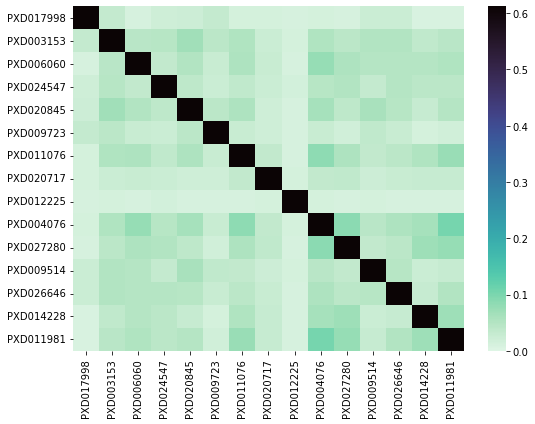

In [25]:
fig = plt.figure(figsize=(8, 6))

ax = sb.heatmap(final, vmax=0.68*0.9, vmin=0, cmap='mako_r')
ax.figure.tight_layout()
plt.savefig("external_predicted.png", dpi=600)

In [27]:
table = pd.read_csv("applicability_data/ground_truth.csv", index_col=0)
table

,PXD017998,PXD003153,PXD006060,PXD024547,PXD020845,PXD009723,PXD011076,PXD020717,PXD012225,PXD004076,PXD027280,PXD009514,PXD026646,PXD014228,PXD011981
PXD017998,1.000000,0.019989,0.033488,0.017159,0.017337,0.036137,0.018194,0.017081,0.003946,0.019608,0.008274,0.006445,0.037606,0.007766,0.009571
PXD003153,0.019989,1.000000,0.080448,0.022533,0.110306,0.020538,0.049461,0.035610,0.007240,0.114413,0.062871,0.008448,0.055676,0.063298,0.055729
PXD006060,0.033488,0.080448,1.000000,0.023210,0.065534,0.022049,0.036250,0.014151,0.019242,0.053606,0.033261,0.006410,0.054569,0.023967,0.019767
PXD024547,0.017159,0.022533,0.023210,1.000000,0.014561,0.008483,0.008841,0.009669,0.020654,0.019299,0.006177,0.000000,0.015067,0.005539,0.004973
PXD020845,0.017337,0.110306,0.065534,0.014561,1.000000,0.017500,0.066626,0.026421,0.009241,0.074670,0.072288,0.003835,0.043181,0.055278,0.045231
PXD009723,0.036137,0.020538,0.022049,0.008483,0.017500,1.000000,0.019027,0.010711,0.000000,0.016363,0.007107,0.007503,0.026151,0.005889,0.002759
PXD011076,0.018194,0.049461,0.036250,0.008841,0.066626,0.019027,1.000000,0.057166,0.011932,0.093775,0.048116,0.001123,0.043072,0.060426,0.046745
PXD020717,0.017081,0.035610,0.014151,0.009669,0.026421,0.010711,0.057166,1.000000,0.007244,0.072809,0.016829,0.001162,0.023843,0.024814,0.032014
PXD012225,0.003946,0.007240,0.019242,0.020654,0.009241,0.000000,0.011932,0.007244,1.000000,0.020877,0.007824,0.002165,0.010892,0.004342,0.003806
PXD004076,0.019608,0.114413,0.053606,0.019299,0.074670,0.016363,0.093775,0.072809,0.020877,1.000000,0.061136,0.004628,0.052891,0.061411,0.062977


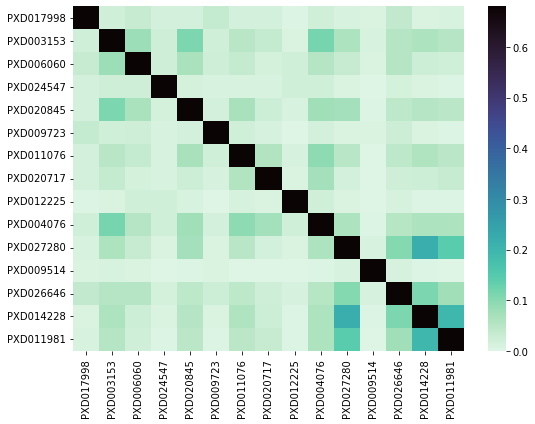

In [28]:
fig = plt.figure(figsize=(8, 6))

ax = sb.heatmap(table, vmax=0.68, cmap='mako_r')
ax.figure.tight_layout()
plt.savefig("external_ground_truth.png", dpi=600)

# UPPERS AND LOWERS

In [29]:
ground = np.array(table)

In [30]:
ground_upper = np.triu(ground)

In [31]:
pred = np.array(table2)

In [32]:
pred_lower = np.tril(pred)

In [33]:
total = ground_upper + pred_lower

In [34]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvitica'

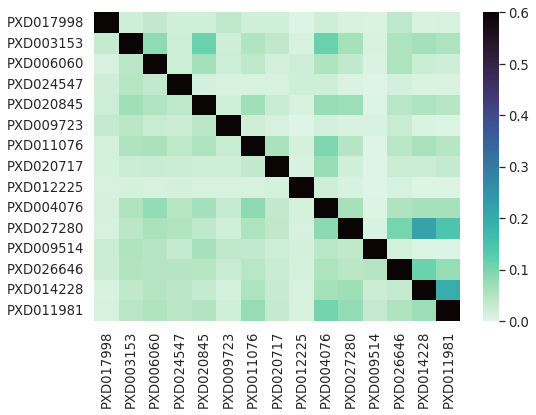

In [35]:
fig = plt.figure(figsize=(8, 6))

sb.set(font_scale=1.2)

ax = sb.heatmap(total, vmax=0.60, cmap='mako_r',
               xticklabels=table.index, yticklabels=table.index)
ax.figure.tight_layout()

plt.savefig("both.png", dpi=600)

In [38]:
test = pd.read_csv("applicability_data/similarity_pairs_psms.txt")
test

,PID1,PID2,Jaccard_Index
0,PXD009723,PXD012225,0.000000
1,PXD024547,PXD009514,0.000000
2,PXD011076,PXD009514,0.001123
3,PXD020717,PXD009514,0.001162
4,PXD012225,PXD009514,0.002165
...,...,...,...
100,PXD026646,PXD014228,0.111277
101,PXD003153,PXD004076,0.114413
102,PXD027280,PXD011981,0.144389
103,PXD014228,PXD011981,0.194747


In [42]:
test["Predicted"] = predicted
test

,PID1,PID2,Jaccard_Index,Predicted
0,PXD009723,PXD012225,0.000000,0.010602
1,PXD024547,PXD009514,0.000000,0.031521
2,PXD011076,PXD009514,0.001123,0.034251
3,PXD020717,PXD009514,0.001162,0.021538
4,PXD012225,PXD009514,0.002165,0.014075
...,...,...,...,...
100,PXD026646,PXD014228,0.111277,0.030828
101,PXD003153,PXD004076,0.114413,0.053251
102,PXD027280,PXD011981,0.144389,0.077800
103,PXD014228,PXD011981,0.194747,0.070405


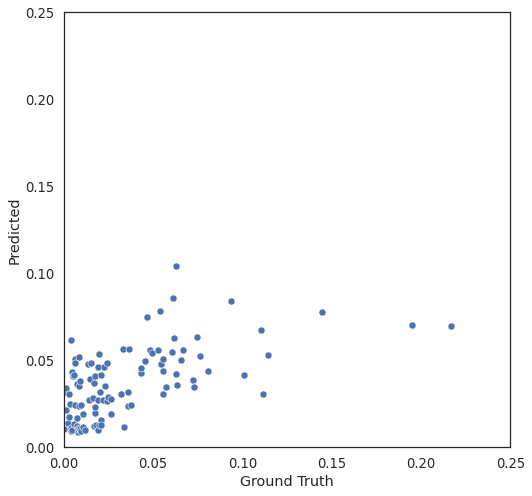

In [49]:
fig = plt.figure(figsize=(8, 8))
sb.set_style("white")
#sb.set_theme("talk")

ax = sb.scatterplot(data=test,x="Jaccard_Index",y="Predicted", s=50)
ax.set(xlabel='Ground Truth', ylabel='Predicted')
ax.set_xlim(0,0.2)
ax.set_ylim(0,0.2)
ax.set_xticks(np.arange(0, 0.26, 0.05))
ax.set_yticks(np.arange(0, 0.26, 0.05))
plt.savefig("scatter_zebra_rice.png", dpi=400)